# 利用 AWS SageMaker BlazingText 对不均衡文本进行多分类

## 过采样实验 Oversampling 实验

样本不平衡的解决思路一般有两种：

1. 从数据层面缓解不平衡的状况：一，欠采样，去除数量过多的样例。二，过采样，扩充数量较少的样例
2. 阈值移动，就是对阈值进行调整。直接基于原始数据训练，进行预测时，用样例的真实观测几率来修正阈值。

由于本实验使用的是 SageMaker 的内置算法，无法修改算法本身，因此考虑从数据层面解决样本不均衡问题。由于本次数据集中某些类别数量过少，因此采用过采样的方法。

过采样方法中，由于是文本类型数据，又选择了回译和 EDA 两种方法。

## 过采样倍数计算方法

由于过采样需要对原数据进行扩充，而过采样处理后的数据又需要和原数据保持一定规律，计算数据增强倍数的取值n的计算方法如下：

- 原始数据各个类别呈递减状态，即使经过上采样处理后的数据也要保持原始数据的一定规律
- 假设最大类别的数量为`a`，类别种类为`b`，最小类别增强后的数量保持在`a/3`和`a/2`之间
- 过采样后的数据为等差递减数列，公差在 `(a-a/3)/b` 到 `(a-a/2)/b` 之间，取一个整数为`c`
- 增强后数据分布：`y(x) = a – c(x-1)`
- `n = math.floor ( y(x) / x类别的当前值)`

In [1]:
import math

'''
计算n值
'''
def calcu_n(name):
    num = get_num_from_name(name)
    
    current_num = group.label.value_counts().iloc[0]
    expected_num = 40000-2000*(num-1)
        
    n = math.floor(expected_num/current_num)
    return n

## 过采样方法一：回译

由于我们是对文本字符串使用blazingtext进行分类，因此可以采用回译的方式。

所谓回译即对原句子进行一次翻译，再翻译回原来的语言，比如英文句子翻译成中文，再翻译回英文，就可以得到一个新的语义一致的句子。

本文采用 AWS Translate 实现回译，由于目前 Translate 支持55种语言，因此一层回译最多可以有54个结果。
但是某些情况下回译结果会和原句子一样，因此需要增加去重工作，实测去重后一般一个句子也可以达到扩充为20-40倍之间。

## 过采样处理二：EDA

EDA 是常用的文本扩充方法，主要包含四种处理手段：同义词替换、随机插入、随机交换、随机删除。

本文直接使用一个开源的 EDA 工具进行文本扩充。合并 EDA 处理后的各个文本，作为过采样实验的数据集。

## 过采样实验

- Step 0 - Setup； 
- Step 1 - 数据集分析； 
- Step 2 - 数据预处理； 
- Step 3 - 处理样本不均衡； 
- Step 4 - 训练模型
- Step 5 - 部署模型和预测

## Step 0 - Setup

指定用于存放训练和模型数据的S3存储桶和前缀。

并指定 IAM 角色用于授予SageMaker访问数据的权限。

In [3]:
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import json
import boto3
from random import shuffle

sess = sagemaker.Session()

role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = 'ray-ai-ml-bjs' #sess.default_bucket() # Replace with your own bucket name if needed
input_prefix = 'classification/blazingtext/UnbalancedTextMulticlassification'

arn:aws-cn:iam::876820548815:role/Sagemaker-Bootcamp-SageMakerExecutionRole-Z3VF78G260T1


## Step 1 - 数据集分析

1. 预览数据

In [4]:
import pandas as pd

step1_df = pd.read_csv('unblance_original_dataset/dataset.csv')
print("行数：" + str(step1_df.shape[0]))
step1_df.head()

行数：188020


,label,title,abstract
0,1,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...
1,1,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...
2,1,Q-workshop,Q-workshop is a Polish company located in Poz...
3,1,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...
4,1,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...


2. 查看一共有哪些类别以及每个类别数据的数量分布情况

In [5]:
count_classes = pd.value_counts(step1_df['label'], sort = True)
print(count_classes)

1     40000
2     38000
3     18000
4     17000
5     16000
6     15000
7     14000
8     13000
9      8000
10     5000
11     3000
12      900
13      100
14       20
Name: label, dtype: int64


3. 每个类别分布图。

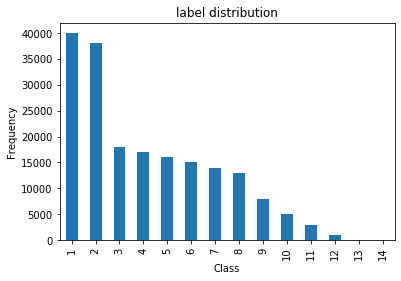

In [6]:
import matplotlib.pyplot as plt

count_classes = step1_df.label.value_counts()
count_classes.plot(kind = 'bar')
plt.title("label distribution")
plt.xlabel("Class")
plt.ylabel("Frequency");

4. 查看数字类别对应的名称

In [8]:
!cat unblance_original_dataset/classes.txt

Company
EducationalInstitution
Artist
Athlete
OfficeHolder
MeanOfTransportation
Building
NaturalPlace
Village
Animal
Plant
Album
Film
WrittenWork


5. 创建从整数索引到类标签的字典映射

In [9]:
index_to_label = {} 
with open("unblance_original_dataset/classes.txt") as f:
    for i,label in enumerate(f.readlines()):
        index_to_label[str(i+1)] = label.strip()
print(index_to_label)

{'1': 'Company', '2': 'EducationalInstitution', '3': 'Artist', '4': 'Athlete', '5': 'OfficeHolder', '6': 'MeanOfTransportation', '7': 'Building', '8': 'NaturalPlace', '9': 'Village', '10': 'Animal', '11': 'Plant', '12': 'Album', '13': 'Film', '14': 'WrittenWork'}


## Step 2 - 数据预处理

1. 去掉空行；
2. 大小写统一；
3. 分词 - 英文分词使用nltk.word_tokenize；中文可以使用jieba分词
4. 转化为BlazingText的数据集格式

In [10]:
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

1. 按照blazingtext的要求，创建从整数索引到以“__label__”开头的类标签的字典映射

In [11]:
index_to_label_final = {}
for key in index_to_label:
    index_to_label_final[key] = "__label__" + str(index_to_label[key]) 

print(index_to_label_final)

{'1': '__label__Company', '2': '__label__EducationalInstitution', '3': '__label__Artist', '4': '__label__Athlete', '5': '__label__OfficeHolder', '6': '__label__MeanOfTransportation', '7': '__label__Building', '8': '__label__NaturalPlace', '9': '__label__Village', '10': '__label__Animal', '11': '__label__Plant', '12': '__label__Album', '13': '__label__Film', '14': '__label__WrittenWork'}


2. 分词和预处理：把Title和Abstract合并，按照blazingtext要求生成新的label格式

In [12]:
def tokenize(series):
    for index, value in series.items():
        series[index] = nltk.word_tokenize(value.lower())
    return series

def preprocess(step1_df):
    
    step1_df = step1_df.dropna(axis=0) 
    
    step2_df = pd.DataFrame()
    step2_df['label'] = step1_df['label']
    step2_df['label'] = step2_df['label'].map(str).map(index_to_label_final)
    step2_df['sentence'] = step1_df["title"].map(str) +","+ step1_df["abstract"].map(str)
    #comments off the tokenize, which will cause the classification_report error
    #step2_df['sentence'] = tokenize(step2_df['sentence']) 
    return step2_df

step2_df = preprocess(step1_df)
step2_df.head(10)

,label,sentence
0,__label__Company,"E. D. Abbott Ltd, Abbott of Farnham E D Abbott..."
1,__label__Company,"Schwan-Stabilo, Schwan-STABILO is a German mak..."
2,__label__Company,"Q-workshop, Q-workshop is a Polish company loc..."
3,__label__Company,"Marvell Software Solutions Israel, Marvell Sof..."
4,__label__Company,"Bergan Mercy Medical Center, Bergan Mercy Medi..."
5,__label__Company,"The Unsigned Guide, The Unsigned Guide is an o..."
6,__label__Company,"Rest of the world, Within sports and games pla..."
7,__label__Company,"Globoforce, Globoforce is a multinational comp..."
8,__label__Company,"Rompetrol, The Rompetrol Group N.V. is a Roman..."
9,__label__Company,"Wave Accounting, Wave is the brand name for a ..."


3. 保留预处理后的数据集作为baseline实验的数据集

In [13]:
import os

os.makedirs('unblance_baseline_dataset', exist_ok = True)
step2_df.to_csv("unblance_baseline_dataset/dataset_baseline.csv", sep=" ", header=0, index=0)

## Step 3 - 处理样本不均衡

对于文本类型不平衡数据，我们采取`回译`和`EDA`这两种过采样方法对数据量少的样本进行增强。

要对上述样本进行样本增强的同时不能太破坏原有数据的规律，即，各个类别的数量变化大致趋势要保持一致。

1. 本实验原数据集label1的数量最多为4w条，label14的数量最少为15条，并且从label1到label14一直呈数量递减。

2. 按照之前给出数据增强倍数，增强后的数据目标为：最少数量类别增强后要在最大数量类别的1/3到1/2之间。也就是40000/3到40000/2之间，也就是133333到20000之间。

3. 保持原有数据规律-大致呈等差递减数列，因此增强后的数据也保持等差递减。公差在(40000-40000/3)/13到(40000-40000/2)/13之间，也就是2051到1538之间，便于计算取值2000作为公差。

4. 因此对于本项目中的数据增强，希望达到的大致数据：首项为40000，公差为2000的等差数列。y(x)=40000-2000(x-1)。增强后数量最少的label14的数量大致为14000

### 过采样方法一：回译和去重

回译方法比较简单，而且不依赖第三方工具，但是这类型过采样方式比较耗时，不适合大规模数据

1. 准备函数

In [14]:
import random
import boto3

# 准备 AWS Translate 客户端
session = boto3.Session(profile_name='global', region_name='us-east-1')
translate_client = session.client('translate')

# 除英语外的54种语言
available_lang = ["af","sq","am","ar","az","bn","bs","bg","zh","zh-TW","hr","cs","da","fa-AF","nl","et","fi","fr","fr-CA","ka","de","el","ha","he",
                  "hi","hu","id","ja","ko","lv","ms","no","fa","ps","pl","pt","ro","ru","sr","sk","sl","so","es","es-MX","sw","sv","tl","ta","th","tr","uk","ur","vi"]

'''
回译函数
'''
def back_translate(text, sourceLanguageCode, targetLanguageCode):
    response1 = translate_client.translate_text(
        Text = text,
        SourceLanguageCode = sourceLanguageCode,
        TargetLanguageCode = targetLanguageCode
    )
    translation_text = response1['TranslatedText']
#     print(translation_text)
    response2 = translate_client.translate_text(
        Text = text,
        SourceLanguageCode = targetLanguageCode,
        TargetLanguageCode = sourceLanguageCode
    )
    return response2['TranslatedText']

'''
对54次回译结果去重，并从set结果中选择n个包含原句子的句子
'''
def get_translation_set(text, n):
    translation_set = set()
    translation_set.add(text)
    for language in available_lang:
        result = back_translate(text, "en", language)
        translation_set.add(result)
    translation_set.remove(text)
    if n-1 <= len(translation_set):
        translation_set = set(random.sample(translation_set, n-1))
    translation_set.add(text)
    return translation_set

'''
得到对应label的回译list
return: [[label,sent1],[label,sent2]...]
'''
def get_label_translation_list(label, sentences, n):
    result = []
    for text in sentences:
        translation_set = get_translation_set(text, n)
        for tanslation in translation_set:
            result.append([label,tanslation])
    return result

2. 单元测试

In [15]:
label = "__label__Company"
sentences = ["E. D. Abbott Ltd, Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trading under that name from 1929."]
get_label_translation_list(label, sentences, 5)

[['__label__Company',
  'Abbott Ltd, Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trading under that name from 1929.'],
 ['__label__Company',
  'E. D. Abbott Ltd, Farnham E D Abbott Limited of Abbott was a British coachbuilding business based in Farnham Surrey trading under that name from 1929.'],
 ['__label__Company',
  'E. D. Abbott Ltd, Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trading under that name from 1929.'],
 ['__label__Company',
  'E. D. Abbot Ltd, Abbot of Farnham E D Abbot Limited was a British coachbuilding business based in Farnham Surrey Trading under that name from 1929.'],
 ['__label__Company',
  'E. D. Abbott Ltd, Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trade under that name from 1929.']]

3. 计算`回译`针对每个类比需要增强的倍数 n1 值

In [20]:
import math

'''
根据label名字反推出id
'''
def get_index_from_label(name):
    num = 0;
    for key in index_to_label_final:
        if index_to_label_final[key] == name:
            num = int(key)
    return num;

'''
计算n1值
'''
def calcu_n1(name, group):
    num = get_index_from_label(name)
    
    current_num = group.label.value_counts().iloc[0]
    expected_num = 40000-2000*(num-1)
        
    n1 = math.floor(expected_num/current_num)
    return n1

4. 分组回译处理 - 这里只处理label11 至 label14

In [21]:
bt_grouped = step2_df.groupby('label')

group1 = bt_grouped.get_group("__label__Company")
back_translate_df = pd.DataFrame(group1)

for name, group in bt_grouped:
    num = get_index_from_label(name)
    
    if num != 1:
        print ("processing: " + str(num) + "," + name)

        n1 = calcu_n1(name, group)
        if n1 > 100:
            label_translation_list = get_label_translation_list(name, group.sentence, n1)
            group_df = pd.DataFrame(label_translation_list,columns=['label','sentence'])
            back_translate_df = back_translate_df.append(group_df)
        else:
            back_translate_df = back_translate_df.append(pd.DataFrame(group))

processing: 12,__label__Album
processing: 10,__label__Animal
processing: 3,__label__Artist
processing: 4,__label__Athlete
processing: 7,__label__Building
processing: 2,__label__EducationalInstitution
processing: 13,__label__Film
processing: 6,__label__MeanOfTransportation
processing: 8,__label__NaturalPlace
processing: 5,__label__OfficeHolder
processing: 11,__label__Plant
processing: 9,__label__Village
processing: 14,__label__WrittenWork


EndpointConnectionError: Could not connect to the endpoint URL: "https://translate.us-east-1.amazonaws.com/"

In [57]:
# due to above error, some catalog has not been back_translate
bt_grouped = step2_df.groupby('label')
group_missing = bt_grouped.get_group("__label__WrittenWork")
print(group_missing.head())

def handle_missing_back_translate(name, missing_groups):    
    num = get_index_from_label(name)

    if num != 1:
        print ("processing: " + str(num) + "," + name)

        n1 = calcu_n1(name, missing_groups)
        if n1 > 100:
            label_translation_list = get_label_translation_list(name, missing_groups.sentence, n1)
            group_df = pd.DataFrame(label_translation_list,columns=['label','sentence'])
            back_translate_df = back_translate_df.append(group_df)
        else:
            back_translate_df = back_translate_df.append(pd.DataFrame(missing_groups))
            
handle_missing_back_translate('__label__WrittenWork',group_missing)

                       label  \
188000  __label__WrittenWork   
188001  __label__WrittenWork   
188002  __label__WrittenWork   
188003  __label__WrittenWork   
188004  __label__WrittenWork   

                                                 sentence  
188000  Embrace (novel), Embrace is a 2001 novel by So...  
188001  British Film (magazine), British Film was a pu...  
188002  Twin Research and Human Genetics, Twin Researc...  
188003  Revista del Museo Argentino de Ciencias Natura...  
188004  The Unicorn Murders, The Unicorn Murders is a ...  
188000    Embrace (novel), Embrace is a 2001 novel by So...
188001    British Film (magazine), British Film was a pu...
188002    Twin Research and Human Genetics, Twin Researc...
188003    Revista del Museo Argentino de Ciencias Natura...
188004    The Unicorn Murders, The Unicorn Murders is a ...
188005    FEU Advocate, Far Eastern University (FEU) Adv...
188006    Hoy (Ecuadorian newspaper), Hoy a morning news...
188007    Company (magazine

5. 查看回译后的数据分布

__label__Company                   40000
__label__EducationalInstitution    38000
__label__Artist                    18000
__label__Athlete                   17000
__label__OfficeHolder              16000
__label__MeanOfTransportation      15000
__label__Building                  14000
__label__NaturalPlace              13000
__label__Village                    8000
__label__Animal                     5000
__label__Film                       3259
__label__Plant                      3000
__label__Album                       900
Name: label, dtype: int64


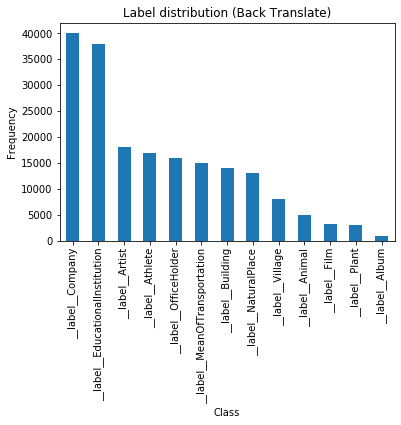

In [56]:
back_tanslate_classes = back_translate_df.label.value_counts()

back_tanslate_classes.plot(kind = 'bar')
plt.title("Label distribution (Back Translate)")
plt.xlabel("Class")
plt.ylabel("Frequency");

print(back_tanslate_classes)

### 过采样方法二：EDA

同义词替换、随机插入、随机交换、随机删除

1. 使用开源EDA工具

In [24]:
!git clone https://github.com/jasonwei20/eda_nlp.git

import nltk

nltk.download('wordnet')

Cloning into 'eda_nlp'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 393 (delta 4), reused 10 (delta 4), pack-reused 379
Receiving objects: 100% (393/393), 20.41 MiB | 6.32 MiB/s, done.
Resolving deltas: 100% (187/187), done.


[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

2. 每个 group 都要进行不同级别的 EDA 处理，把每个 group 单独保存为一个文件

In [51]:
eda_grouped = step2_df.groupby('label')
#eda_grouped = back_translate_df.groupby('label') ##基于`回译`结果做EDA
eda_file_path = 'unblance_oversampling_eda_groups'
os.makedirs(eda_file_path, exist_ok = True)

for name, group in eda_grouped:
    every_group_df = pd.DataFrame(group)
    filename = eda_file_path + "/group" + name + ".csv"
    every_group_df.to_csv(filename, sep="\t", header=0, index=0)

3. 计算 EDA 阶段需要增强的倍数 n2 值

In [52]:
import math

'''
计算n2值
'''
def calcu_n2(name, group):
    num = get_index_from_label(name)
    
    current_num = group.label.value_counts().iloc[0]
    expected_num = 40000-2000*(num-1)
        
    n2 = math.floor(expected_num/current_num)-1
    return n2

4. EDA工具对每一组文件进行处理


- Synonym Replacement (SR): Randomly choose n words from the sentence that are not stop words. Replace each of these words with one of its synonyms chosen at random.
- Random Insertion (RI): Find a random synonym of a random word in the sentence that is not a stop word. Insert that synonym into a random position in the sentence. Do this n times.
- Random Swap (RS): Randomly choose two words in the sentence and swap their positions. Do this n times.
- Random Deletion (RD): For each word in the sentence, randomly remove it with probability p.


In [58]:
from shutil import copyfile

eda_grouped = step2_df.groupby('label')
#eda_grouped = back_translate_df.groupby('label') ##基于`回译`结果做EDA

for name, group in eda_grouped:
    num = get_index_from_label(name)
    n2 = calcu_n2(name,group)
    #print('calcu_n2',n2)
    filename = "group" + name + ".csv"
    if n2 > 0:
        !python eda_nlp/code/augment.py --input=$eda_file_path/$filename --num_aug=$n2 --alpha_sr=0.05 --alpha_ri=0.0 --alpha_rs=0.1 --alpha_rd=0.0 
    else:
        copyfile(eda_file_path + "/" + filename, eda_file_path + "/" + "eda_" + filename)
        print("copied file: " + filename)

generated augmented sentences with eda for unblance_oversampling_eda_groups/group__label__Album.csv to unblance_oversampling_eda_groups/eda_group__label__Album.csv with num_aug=19
generated augmented sentences with eda for unblance_oversampling_eda_groups/group__label__Animal.csv to unblance_oversampling_eda_groups/eda_group__label__Animal.csv with num_aug=3
generated augmented sentences with eda for unblance_oversampling_eda_groups/group__label__Artist.csv to unblance_oversampling_eda_groups/eda_group__label__Artist.csv with num_aug=1
generated augmented sentences with eda for unblance_oversampling_eda_groups/group__label__Athlete.csv to unblance_oversampling_eda_groups/eda_group__label__Athlete.csv with num_aug=1
generated augmented sentences with eda for unblance_oversampling_eda_groups/group__label__Building.csv to unblance_oversampling_eda_groups/eda_group__label__Building.csv with num_aug=1
copied file: group__label__Company.csv
copied file: group__label__EducationalInstitution.c

5. 合并EDA处理后的各个文件

In [60]:
import os

step3_df = pd.DataFrame(columns=['label', 'sentence'])

for root,dirs,files in os.walk(eda_file_path):
    for file in files:
        #获取文件路径
        file_path = os.path.join(root,file)

        if "eda_group__" in file_path:
            print(file_path)
            file_df = pd.read_csv(file_path, sep="\t", header=0, names=['label', 'sentence'])
            step3_df = step3_df.append(file_df)

unblance_oversampling_eda_groups/eda_group__label__Athlete.csv
unblance_oversampling_eda_groups/eda_group__label__Plant.csv
unblance_oversampling_eda_groups/eda_group__label__NaturalPlace.csv
unblance_oversampling_eda_groups/eda_group__label__Film.csv
unblance_oversampling_eda_groups/eda_group__label__WrittenWork.csv
unblance_oversampling_eda_groups/eda_group__label__MeanOfTransportation.csv
unblance_oversampling_eda_groups/eda_group__label__Artist.csv
unblance_oversampling_eda_groups/eda_group__label__EducationalInstitution.csv
unblance_oversampling_eda_groups/eda_group__label__OfficeHolder.csv
unblance_oversampling_eda_groups/eda_group__label__Album.csv
unblance_oversampling_eda_groups/eda_group__label__Building.csv
unblance_oversampling_eda_groups/eda_group__label__Village.csv
unblance_oversampling_eda_groups/eda_group__label__Company.csv
unblance_oversampling_eda_groups/eda_group__label__Animal.csv


6. 查看 EDA 处理后的样本分布

__label__Company                   39999
__label__EducationalInstitution    37999
__label__Artist                    35999
__label__Athlete                   33999
__label__OfficeHolder              31999
__label__MeanOfTransportation      29999
__label__Building                  27999
__label__NaturalPlace              25999
__label__Village                   23999
__label__Plant                     14999
__label__Animal                    14999
__label__Album                      9899
__label__Film                       8099
__label__WrittenWork                7019
Name: label, dtype: int64


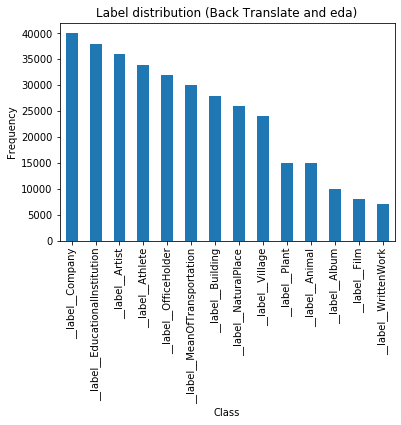

In [61]:
translate_eda_classes = step3_df.label.value_counts()
translate_eda_classes.plot(kind = 'bar')
plt.title("Label distribution (Back Translate and eda)")
plt.xlabel("Class")
plt.ylabel("Frequency");

print(translate_eda_classes)

7. 保存EDA处理并合并后的数据

In [63]:
oversampling_file_path = 'oversampling_dataset'
os.makedirs(oversampling_file_path, exist_ok = True)

step3_df.to_csv(oversampling_file_path + "/dataset_oversampling.csv", sep=" ", header=0, index=0)

## Step4 - 模型训练

1. 划分训练集和测试集, 85% 训练集，15% 验证集

In [64]:
import numpy as np
from sklearn.model_selection import train_test_split

sampling_train, sampling_test = train_test_split(step3_df, test_size=0.15)
sampling_train.to_csv(oversampling_file_path + "/sampling_train.csv", sep=" ", header=0, index=0)
sampling_test.to_csv(oversampling_file_path + "/sampling_test.csv", sep=" ", header=0, index=0)

2. 上传到S3

In [66]:
train_channel = input_prefix + '/oversampling' + '/train'
validation_channel = input_prefix + '/oversampling' + '/validation'

sess.upload_data(path=oversampling_file_path + '/sampling_train.csv', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path=oversampling_file_path+ '/sampling_test.csv', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

3. 获取blazingtext模型

In [67]:
s3_output_location = 's3://{}/{}/sampling/output'.format(bucket, input_prefix)
region_name = boto3.Session().region_name

container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Using SageMaker BlazingText container: 390948362332.dkr.ecr.cn-north-1.amazonaws.com.cn/blazingtext:latest (cn-north-1)


4. 创建训练预测模型和超参调优

In [68]:
sampling_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

sampling_model.set_hyperparameters(mode="supervised",
                            epochs=10,
                            min_count=2,
                            learning_rate=0.05,
                            vector_dim=10,
                            early_stopping=True,
                            patience=4,
                            min_epochs=5,
                            word_ngrams=2)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


5. 模型输入

In [69]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')

validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data}

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


6. 模型训练

In [70]:
sampling_model.fit(inputs=data_channels, logs=True)

2020-11-18 03:47:21 Starting - Starting the training job...
2020-11-18 03:47:23 Starting - Launching requested ML instances......
2020-11-18 03:48:36 Starting - Preparing the instances for training......
2020-11-18 03:49:47 Downloading - Downloading input data...
2020-11-18 03:50:13 Training - Training image download completed. Training in progress.Arguments: train
[11/18/2020 03:50:14 WARNING 139996959356288] Loggers have already been setup.
[11/18/2020 03:50:14 WARNING 139996959356288] Loggers have already been setup.
[11/18/2020 03:50:14 INFO 139996959356288] nvidia-smi took: 0.025358200073242188 secs to identify 0 gpus
[11/18/2020 03:50:14 INFO 139996959356288] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[11/18/2020 03:50:14 INFO 139996959356288] Processing /opt/ml/input/data/train/sampling_train.csv . File size: 88.80525398254395 MB
[11/18/2020 03:50:14 INFO 139996959356288] Processing /opt/ml/input/data/vali

## Step5 - Oversampling 模型部署

In [71]:
sampling_classifier = sampling_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: blazingtext-2020-11-18-03-47-21-521


-------------!

## Step 6 - Oversampling 模型评估和测试

In [72]:
from sklearn.metrics import classification_report
import json

sentenses = sampling_test['sentence'].tolist()
# print(sentenses)

payload = {"instances" : sentenses}
response = sampling_classifier.predict(json.dumps(payload))
predictions = json.loads(response)
# print(predictions)

predict_label = []
for one in predictions:
#     print(one['label'][0])
    predict_label.append(one['label'][0])
# print(predict_label)

real_label = sampling_test['label'].tolist()
# print(real_label)

sampling_report = classification_report(real_label, predict_label)
print(sampling_report)

                                 precision    recall  f1-score   support

                 __label__Album       0.99      1.00      1.00      1519
                __label__Animal       1.00      0.99      0.99      2209
                __label__Artist       0.99      0.99      0.99      5383
               __label__Athlete       1.00      1.00      1.00      5142
              __label__Building       0.99      0.99      0.99      4084
               __label__Company       0.98      0.99      0.99      5959
__label__EducationalInstitution       0.99      0.99      0.99      5770
                  __label__Film       1.00      1.00      1.00      1189
  __label__MeanOfTransportation       0.99      0.99      0.99      4455
          __label__NaturalPlace       0.99      1.00      1.00      3942
          __label__OfficeHolder       0.99      0.99      0.99      4839
                 __label__Plant       0.99      1.00      1.00      2312
               __label__Village       1.00      1.

2. 预测结束，删除endpoint

In [73]:
sampling_classifier.delete_endpoint()

# 经过样本不均衡处理的Oversampling超参调优实验

    Step 1 - 超参自动调优配置 learning_rate， vector_dim， word_ngrams
    Step 2 - 启动超参数优化作业和模型训练
    Step 3 - 模型部署，评估和测试


## Step 1 设置超参数优化作业

这里我们没有设置learning_rate, vector_dim, word_ngrams 三个超参，让SageMaker帮我们进行超参自动调优

In [74]:
sampling_hyperparameter_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

sampling_hyperparameter_model.set_hyperparameters(
                            mode="supervised",
                            epochs=10,
                            min_count=2,
                            early_stopping=True,
                            patience=4,
                            min_epochs=5)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [75]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'learning_rate': ContinuousParameter(0.03, 0.06),
                         'vector_dim': IntegerParameter(100, 200),
                         'word_ngrams': IntegerParameter(1, 3)}

objective_metric_name = 'validation:accuracy'

tuner = HyperparameterTuner(sampling_hyperparameter_model,
                            objective_metric_name,
                            hyperparameter_ranges,
                            objective_type='Maximize',
                            max_jobs=9,
                            max_parallel_jobs=3)

## Step 2 - 启动超参数优化作业和模型训练

In [80]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H-%M-%S")
print(current_time)

tuner.fit(inputs=data_channels, job_name="hyper-oversampling-job"+current_time, logs=True)

tuner.wait()

05-09-29
...................................................................................................................................................................................................!


In [81]:
tuner.describe()['BestTrainingJob']

{'TrainingJobName': 'hyper-oversampling-job05-09-29-009-b3a0ec48',
 'TrainingJobArn': 'arn:aws-cn:sagemaker:cn-north-1:876820548815:training-job/hyper-oversampling-job05-09-29-009-b3a0ec48',
 'CreationTime': datetime.datetime(2020, 11, 18, 5, 21, 38, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2020, 11, 18, 5, 24, 6, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2020, 11, 18, 5, 25, 20, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'learning_rate': '0.059442906196165005',
  'vector_dim': '149',
  'word_ngrams': '1'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:accuracy',
  'Value': 0.992900013923645},
 'ObjectiveStatus': 'Succeeded'}

In [82]:
tuner.best_training_job()

'hyper-oversampling-job05-09-29-009-b3a0ec48'

In [83]:
sampling_hyperparameter_classifier = tuner.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


2020-11-18 05:25:20 Starting - Preparing the instances for training
2020-11-18 05:25:20 Downloading - Downloading input data
2020-11-18 05:25:20 Training - Training image download completed. Training in progress.
2020-11-18 05:25:20 Uploading - Uploading generated training model
2020-11-18 05:25:20 Completed - Training job completedArguments: train
[11/18/2020 05:24:37 WARNING 139840286659968] Loggers have already been setup.
[11/18/2020 05:24:37 WARNING 139840286659968] Loggers have already been setup.
[11/18/2020 05:24:37 INFO 139840286659968] nvidia-smi took: 0.02535247802734375 secs to identify 0 gpus
[11/18/2020 05:24:37 INFO 139840286659968] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[11/18/2020 05:24:37 INFO 139840286659968] tuning_objective_metric: validation:accuracy
[11/18/2020 05:24:37 INFO 139840286659968] Processing /opt/ml/input/data/train/sampling_train.csv . File size: 88.80525398254395 MB
[11/18/

## Step 3 模型评估和测试

In [85]:
from sklearn.metrics import classification_report
import json

sentences = sampling_test['sentence'].tolist()
# print(sentenses)

payload = {"instances" : sentences}
response = sampling_hyperparameter_classifier.predict(json.dumps(payload))
predictions = json.loads(response)
# print(predictions)

predict_label = []
for one in predictions:
#     print(one['label'][0])
    predict_label.append(one['label'][0])
# print(predict_label)

real_label = sampling_test['label'].tolist()
# print(real_label)

sampling_hyperparameter_report = classification_report(real_label, predict_label)
print(sampling_hyperparameter_report)

print(sampling_report)

                                 precision    recall  f1-score   support

                 __label__Album       0.99      1.00      1.00      1519
                __label__Animal       1.00      1.00      1.00      2209
                __label__Artist       0.99      0.99      0.99      5383
               __label__Athlete       1.00      1.00      1.00      5142
              __label__Building       0.99      0.99      0.99      4084
               __label__Company       0.98      0.99      0.99      5959
__label__EducationalInstitution       0.99      0.99      0.99      5770
                  __label__Film       1.00      1.00      1.00      1189
  __label__MeanOfTransportation       1.00      1.00      1.00      4455
          __label__NaturalPlace       1.00      1.00      1.00      3942
          __label__OfficeHolder       0.99      0.99      0.99      4839
                 __label__Plant       1.00      1.00      1.00      2312
               __label__Village       1.00      1.

## 预测结束，删除endpoint


In [ ]:
sampling_hyperparameter_classifier.delete_endpoint()